<a href="https://colab.research.google.com/github/SarkarPriyanshu/NoxEmission/blob/main/Nox_Emission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nox Emission Analysis/Prediction

In [1]:
!pip3 install -U ucimlrepo --q

# Libraries

In [2]:
# Basic Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Sklearn Models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

# Basic Setup
sns.set_style('dark')
plt.style.use("ggplot")
sns.set_palette('cubehelix')
sns.cubehelix_palette(as_cmap=True)

import warnings
warnings.simplefilter(action='ignore')

# Data Loading

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
gas_turbine_co_and_nox_emission_data_set = fetch_ucirepo(id=551)

# data (as pandas dataframes)
df = gas_turbine_co_and_nox_emission_data_set.data.features

# metadata
print(gas_turbine_co_and_nox_emission_data_set.metadata)

# variable information
print(gas_turbine_co_and_nox_emission_data_set.variables)

{'uci_id': 551, 'name': 'Gas Turbine CO and NOx Emission Data Set', 'repository_url': 'https://archive.ics.uci.edu/dataset/551/gas+turbine+co+and+nox+emission+data+set', 'data_url': 'https://archive.ics.uci.edu/static/public/551/data.csv', 'abstract': 'The dataset contains 36733 instances of 11 sensor measures aggregated over one hour, from a gas turbine located in Turkey for the purpose of studying flue gas emissions, namely CO and NOx.', 'area': 'Computer Science', 'tasks': ['Regression', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 36733, 'num_features': 12, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C5WC95', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': "The dataset contains 36733 instances of 11 sensor measures aggregated over one hour (by mea

## Meta Data

- Ambient temperature (AT) Celcius
- Ambient pressure (AP) Mbar
- Ambient humidity (AH) %RH
- Air filter difference pressure (AFDP) Mbar
- Gas turbine exhaust pressure (GTEP) Mbar
- Turbine inlet temperature (TIT) Celcius
- Turbine after temperature (TAT) Celcius
- Compressor discharge pressure (CDP) Mbar
- Turbine energy yield (TEY) MWH
- Carbon monoxide (CO) mg/m3
- Nitrogen oxides (NOx) mg/m3

# Basic Analysis

In [4]:
df.shape

(36733, 12)

In [5]:
df.head()

,year,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,2011,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,81.952
1,2011,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,82.377
2,2011,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,83.776
3,2011,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,82.505
4,2011,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,82.028


In [ ]:
df.isna().sum().reset_index().rename(columns={'index':'Features',0:'NaN Counts'})

,Features,NaN Counts
0,year,0
1,AT,0
2,AP,0
3,AH,0
4,AFDP,0
5,GTEP,0
6,TIT,0
7,TAT,0
8,TEY,0
9,CDP,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36733 entries, 0 to 36732
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    36733 non-null  int64  
 1   AT      36733 non-null  float64
 2   AP      36733 non-null  float64
 3   AH      36733 non-null  float64
 4   AFDP    36733 non-null  float64
 5   GTEP    36733 non-null  float64
 6   TIT     36733 non-null  float64
 7   TAT     36733 non-null  float64
 8   TEY     36733 non-null  float64
 9   CDP     36733 non-null  float64
 10  CO      36733 non-null  float64
 11  NOX     36733 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 3.4 MB


In [ ]:
describe = df.describe().T
describe['skew'] = df.skew()
describe['kurtosis'] = df.kurtosis()
describe

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
year,36733.0,2012.985735,1.418965,2011.000000,2012.0000,2013.0000,2014.0000,2015.0000,0.023625,-1.310677
AT,36733.0,17.712726,7.447451,-6.234800,11.7810,17.8010,23.6650,37.1030,-0.043547,-0.826600
AP,36733.0,1013.070165,6.463346,985.850000,1008.8000,1012.6000,1017.0000,1036.6000,0.194121,0.441993
AH,36733.0,77.867015,14.461355,24.085000,68.1880,80.4700,89.3760,100.2000,-0.628034,-0.274590
AFDP,36733.0,3.925518,0.773936,2.087400,3.3556,3.9377,4.3769,7.6106,0.381097,0.224626
GTEP,36733.0,25.563801,4.195957,17.698000,23.1290,25.1040,29.0610,40.7160,0.329021,-0.653853
TIT,36733.0,1081.428084,17.536373,1000.800000,1071.8000,1085.9000,1097.0000,1100.9000,-0.888278,-0.045755
TAT,36733.0,546.158517,6.842360,511.040000,544.7200,549.8800,550.0400,550.6100,-1.755907,2.016792
TEY,36733.0,133.506404,15.618634,100.020000,124.4500,133.7300,144.0800,179.5000,0.116555,-0.500196
CDP,36733.0,12.060525,1.088795,9.851800,11.4350,11.9650,12.8550,15.1590,0.236792,-0.631588


In [ ]:
df.duplicated().sum()

7

In [ ]:
df.shape

(36733, 12)

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.reset_index(drop=True,inplace=True)

In [8]:
print('Feature, Uniques, Top 5 values ')
for feature in df.columns.to_list():
  print(f'{feature}  {df[feature].nunique()}  {df[feature].unique()[:5]}')

Feature, Uniques, Top 5 values 
year  5  [2011 2012 2013 2014 2015]
AT  22523  [4.5878 4.2932 3.9045 3.7436 3.7516]
AP  791  [1018.7 1018.3 1018.4 1017.8 1017.7]
AH  25708  [83.675 84.235 84.858 85.434 85.182]
AFDP  20495  [3.5758 3.5709 3.5828 3.5808 3.5781]
GTEP  12967  [23.979 23.951 23.99  23.911 23.917]
TIT  799  [1086.2 1086.1 1086.5 1085.9 1086. ]
TAT  2769  [549.83 550.05 550.19 550.17 550.  ]
TEY  6236  [134.67 135.1  135.03 134.68 134.66]
CDP  4447  [11.898 11.892 12.042 11.99  11.91 ]
CO  26185  [0.32663 0.44784 0.45144 0.23107 0.26747]
NOX  23637  [81.952 82.377 83.776 82.505 82.028]


#### Gas Turbine Operation Flow

##### 1. Air Intake
- **Ambient Temperature (AT)**: Affects air density; higher temperatures can reduce efficiency.
- **Ambient Pressure (AP)**: Influences the mass of incoming air; higher pressure can improve performance.
- **Ambient Humidity (AH)**: Impacts air density; high humidity can decrease efficiency.

##### 2. Compression
- Air is compressed by the compressor, increasing pressure and temperature.
- **Compressor Discharge Pressure (CDP)**: Measures air pressure after compression.

##### 3. Fuel Injection
- Compressed air enters the combustion chamber, where fuel is injected and mixed.

##### 4. Combustion
- The fuel-air mixture is ignited, creating high-temperature, high-pressure gases.
- **Turbine Inlet Temperature (TIT)**: Indicates gas temperature entering the turbine.

##### 5. Turbine Expansion
- Hot gases expand through the turbine, spinning it and generating mechanical energy.
- **Turbine After Temperature (TAT)**: Measures the temperature of gases exiting the turbine.

##### 6. Power Generation
- The spinning turbine drives a generator, producing electrical energy.
- **Turbine Energy Yield (TEY)**: Represents the amount of electrical energy produced.

##### 7. Exhaust Release
- Exhaust gases exit the turbine at lower pressure and temperature.
- **Gas Turbine Exhaust Pressure (GTEP)**: Measures the pressure of the exhaust gases.

##### 8. Emission Monitoring
- Exhaust gases contain pollutants that need monitoring.
- **Carbon Monoxide (CO)**: Indicates incomplete combustion; high levels signal inefficiencies.
- **Nitrogen Oxides (NOx)**: Important for compliance; high levels indicate potential pollution.

##### 9. Heat Recovery (in Combined Cycle Plants)
- Exhaust gases are routed to a Heat Recovery Steam Generator (HRSG) for additional power generation.

##### 10. Final Emission
- After emission control, cooled exhaust gases are released into the atmosphere.


# EDA

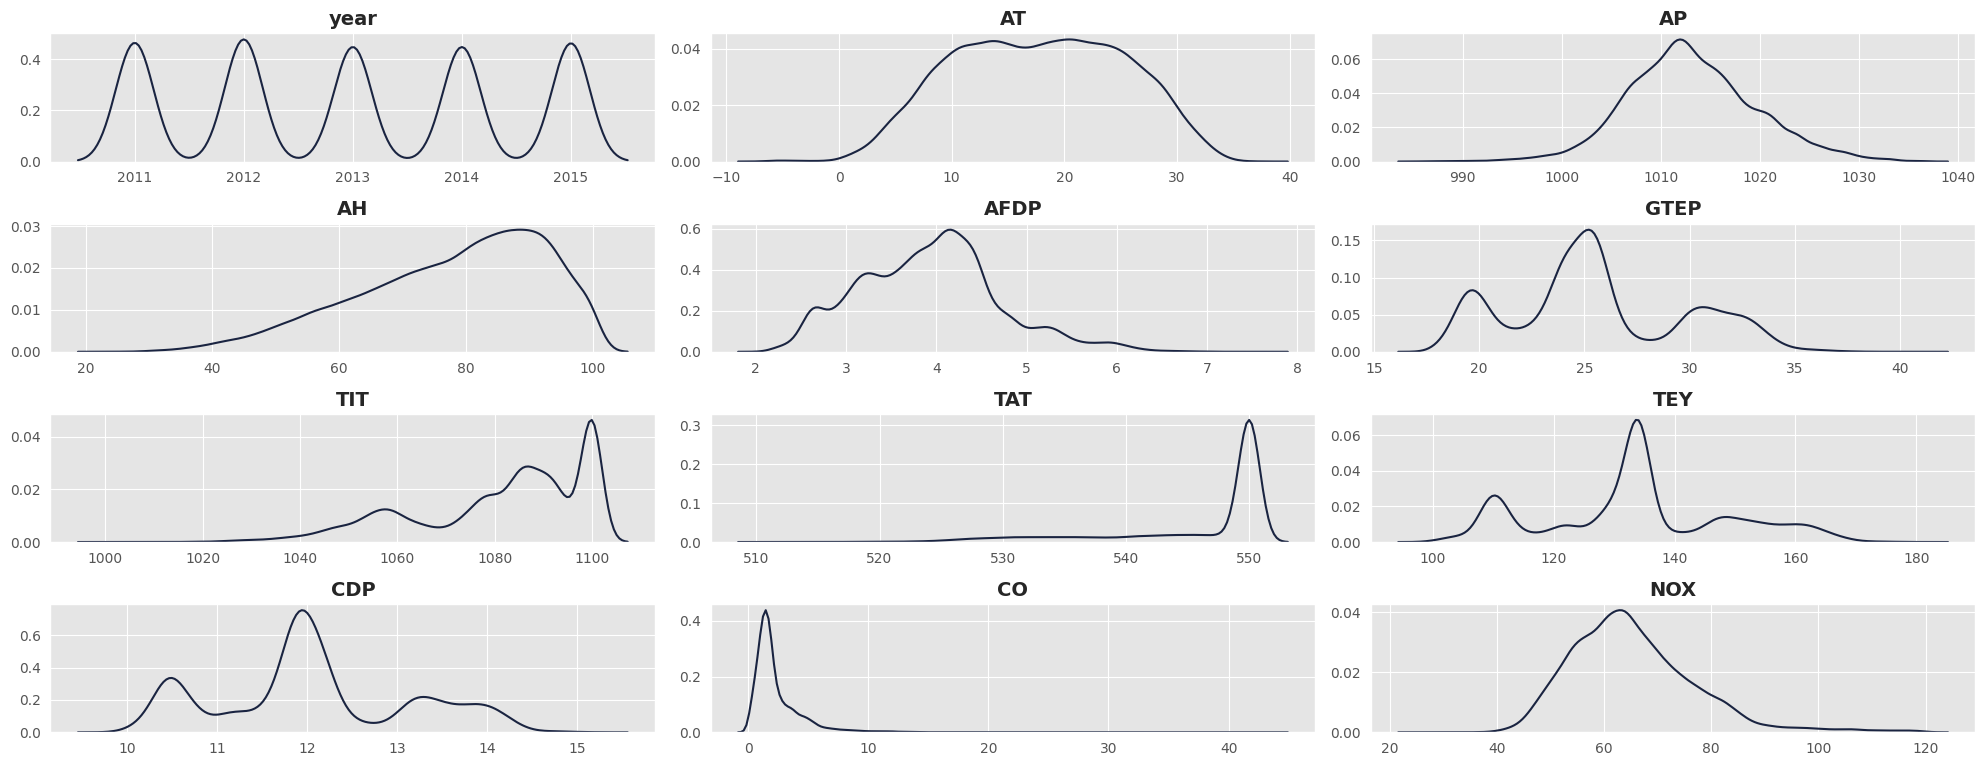

In [ ]:
featureNames = df.columns.to_list()
fig,axes = plt.subplots(4,3,figsize=(20,8))

for col,ax in zip(featureNames,axes.flatten()):
  sns.kdeplot(data=df,x=col,ax=ax)
  ax.set_title(f'{col}', fontsize=14, fontweight='bold')
  ax.set_xlabel('')
  ax.set_ylabel('')

plt.tight_layout(rect=[0,0,1,0.97])
plt.show()

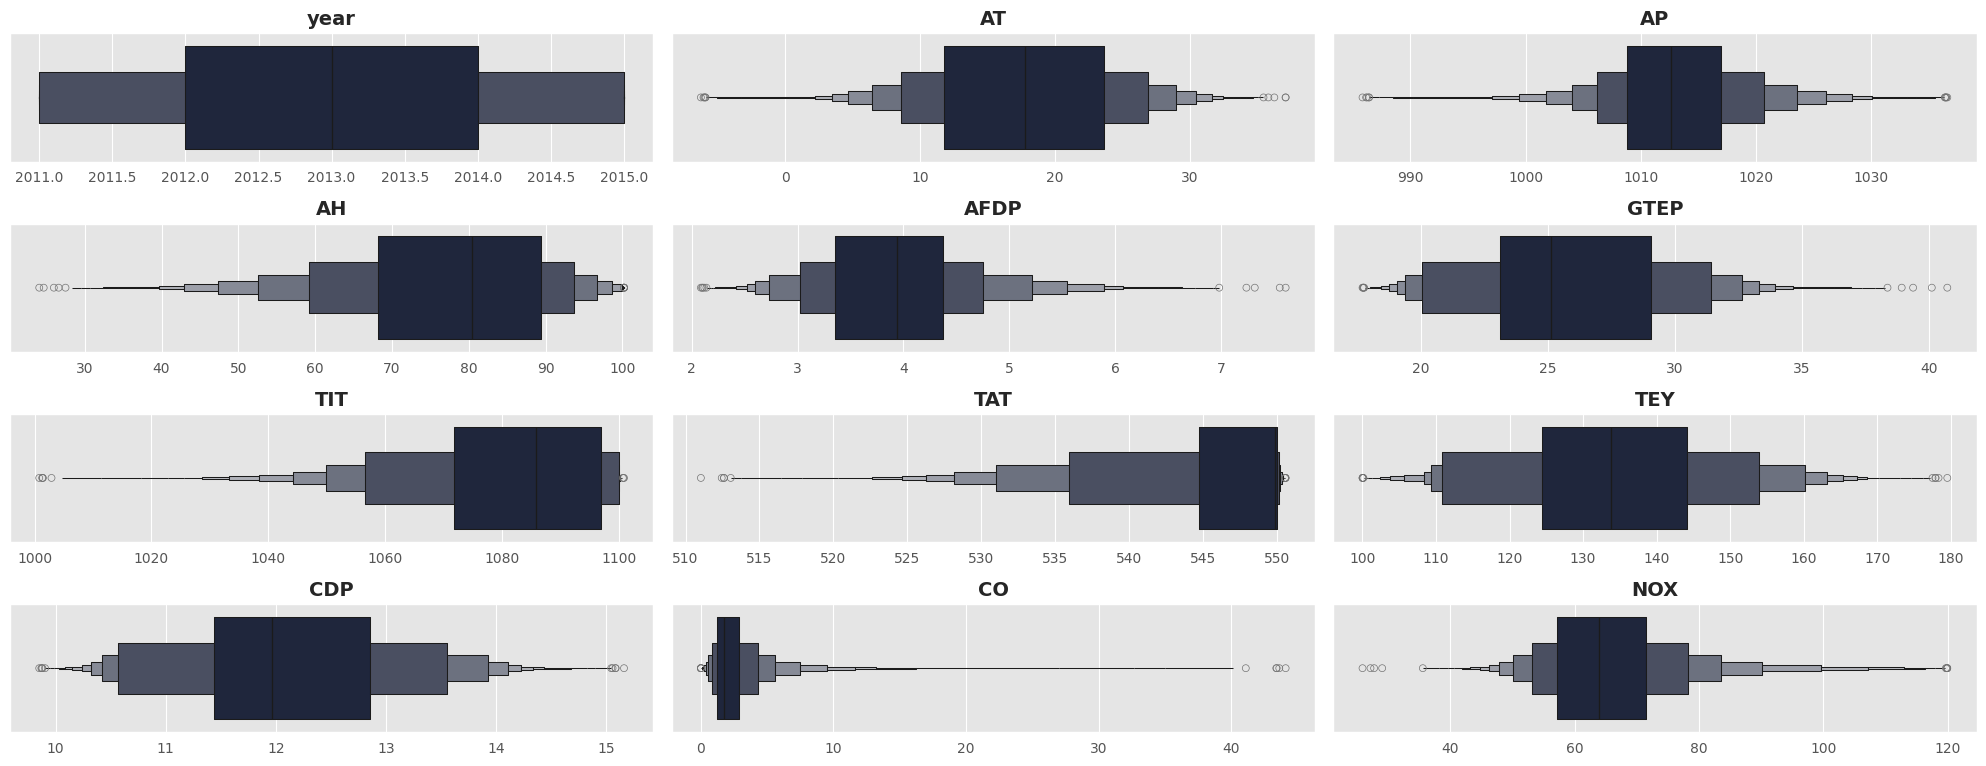

In [ ]:
featureNames = df.columns.to_list()
fig,axes = plt.subplots(4,3,figsize=(20,8))

for col,ax in zip(featureNames,axes.flatten()):
  sns.boxenplot(data=df,x=col,ax=ax)
  ax.set_title(f'{col}', fontsize=14, fontweight='bold')
  ax.set_xlabel('')
  ax.set_ylabel('')

plt.tight_layout(rect=[0,0,1,0.97])
plt.show()

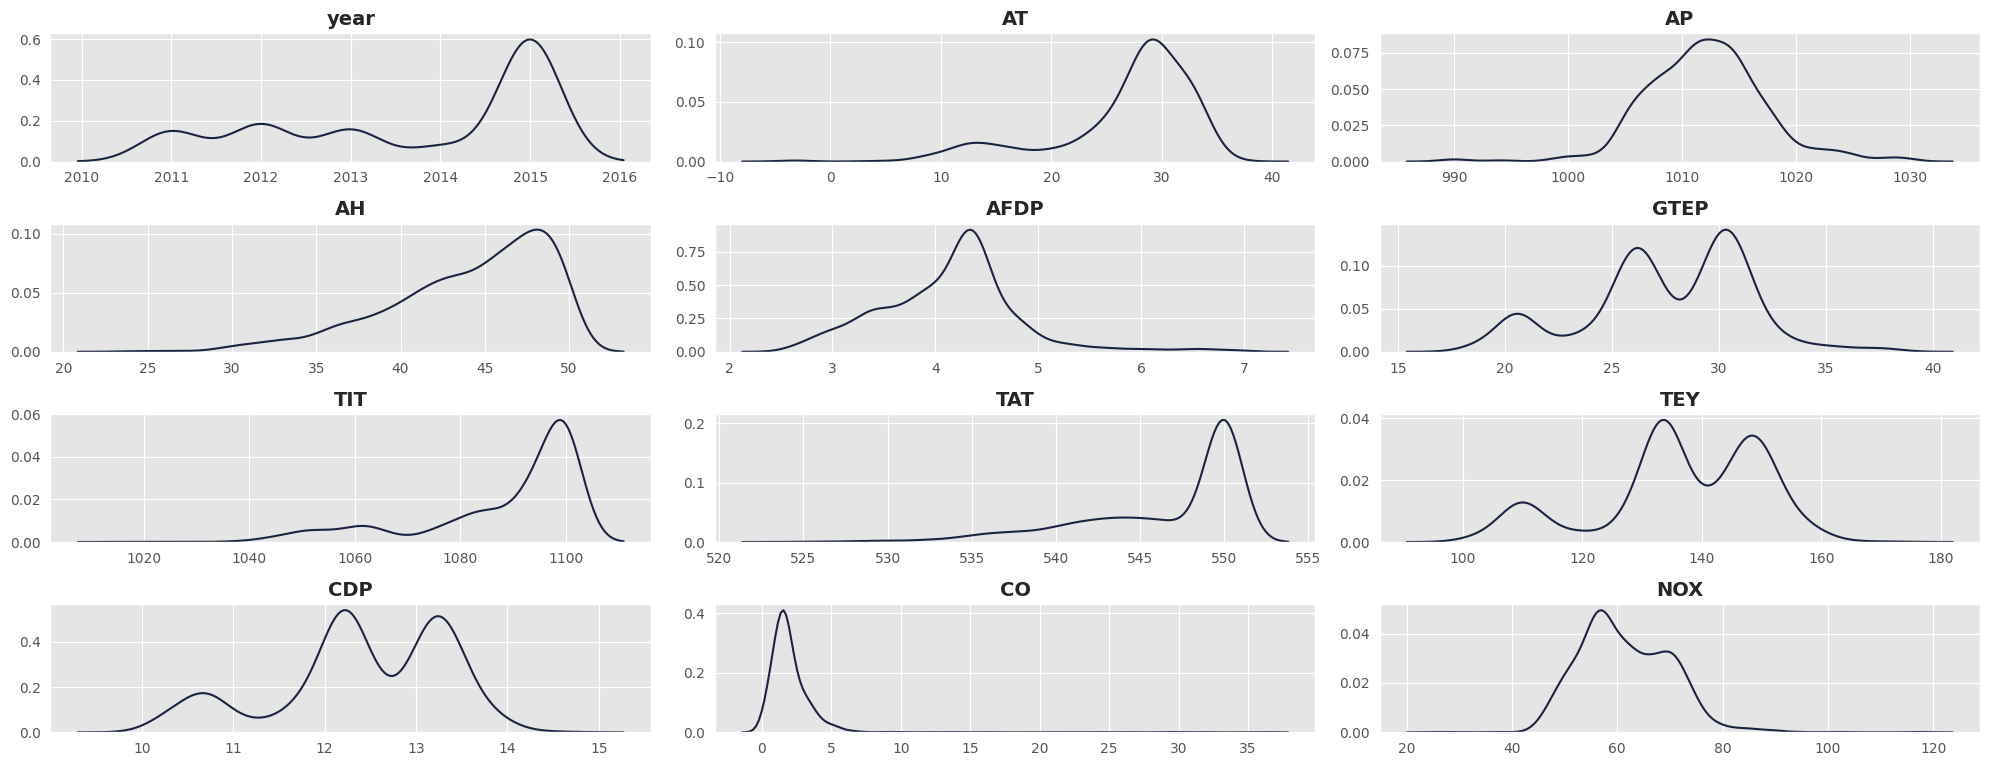

In [ ]:
AH_df = df.query('AH >= 20 & AH <= 50')
featureNames = AH_df.columns.to_list()
fig,axes = plt.subplots(4,3,figsize=(20,8))

for col,ax in zip(featureNames,axes.flatten()):
  sns.kdeplot(data=AH_df,x=col,ax=ax)
  ax.set_title(f'{col}', fontsize=14, fontweight='bold')
  ax.set_xlabel('')
  ax.set_ylabel('')

plt.tight_layout(rect=[0,0,1,0.97])
plt.show()

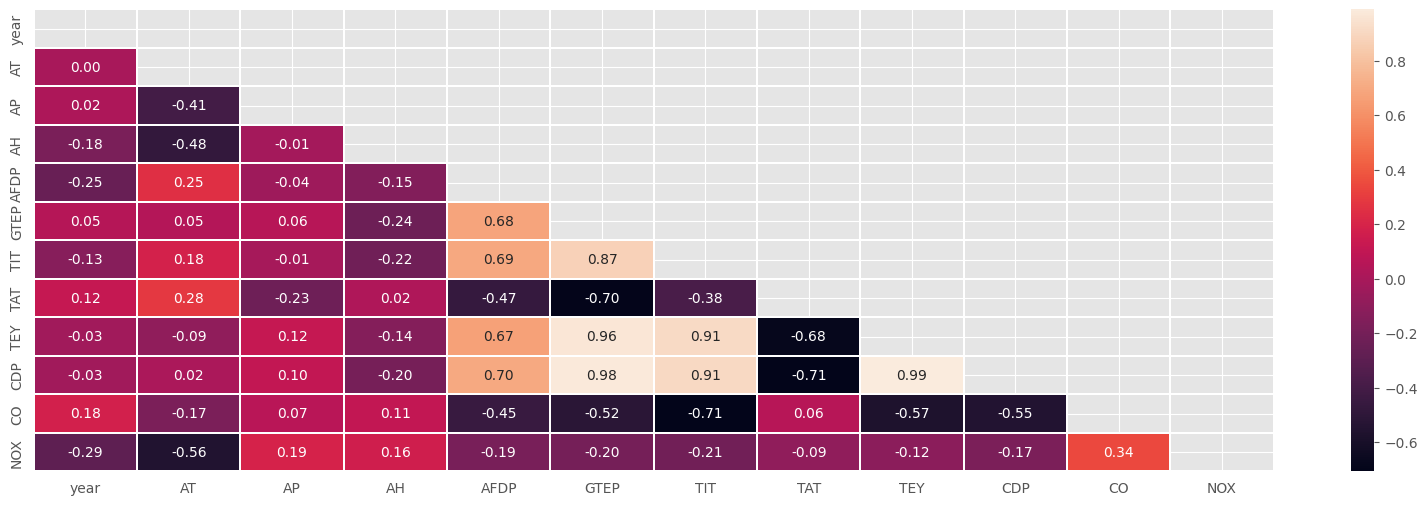

In [ ]:
plt.figure(figsize=(20,6))
correlation = df.corr()
mask = np.triu(correlation)
sns.heatmap(correlation,annot=True,mask=mask,fmt='.2f',linewidths=0.05)
plt.show()

# Data Preprocessing

In [9]:
X,y = df.drop('NOX',axis=1),df['NOX']

In [33]:
X_train, X_other, y_train, y_other = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state=42
                                                    )

X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,
                                                    test_size=0.2,
                                                    random_state=42)

In [11]:
X_train.shape,X_test.shape,X_val.shape

((29380, 11), (1470, 11), (5876, 11))

In [12]:
rs = RobustScaler()
X_train_sm = rs.fit_transform(X_train)
X_val_sm = rs.transform(X_val)

In [13]:
X_train_sm = sm.add_constant(X_train)
X_val_sm = sm.add_constant(X_val)

# Feature Selection, Feature Significance

  - We gonna check the models perfermance using statsmodels `OLS` method
  - If in summary features `P-value > 0.05` means that feature have less significance in terms of predicting Y
  - Also we are going to check the `VIF (1/1-R^2)`, to remove `Multicolinarity`

In [14]:
model = sm.OLS(y_train,X_train_sm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    NOX   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     3780.
Date:                Wed, 13 Nov 2024   Prob (F-statistic):               0.00
Time:                        07:23:56   Log-Likelihood:            -1.0105e+05
No. Observations:               29380   AIC:                         2.021e+05
Df Residuals:                   29368   BIC:                         2.022e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3601.4348    117.559     30.635      0.0

In [17]:
threshold = int(1/(1-0.8))
threshold

5

In [16]:
vif = pd.DataFrame()
vif['Features'] = X_train_sm.columns
vif['Vif'] = [round(variance_inflation_factor(X_train_sm.values,i),2) for i in range(X_train_sm.shape[1])]
vif['Failed'] = vif['Vif'].values < threshold
vif.sort_values('Vif',ascending=False)

,Features,Vif,Failed
0,const,7136039.09,False
10,CDP,279.49,False
9,TEY,267.40,False
7,TIT,83.94,False
6,GTEP,31.83,False
8,TAT,25.05,False
2,AT,8.49,False
1,year,3.46,True
5,AFDP,2.61,True
11,CO,2.42,True


In [18]:
Features_to_drop = ['CDP']

In [19]:
X_train_sm.drop(Features_to_drop,axis=1,inplace=True)

In [20]:
model = sm.OLS(y_train,X_train_sm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    NOX   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     4156.
Date:                Wed, 13 Nov 2024   Prob (F-statistic):               0.00
Time:                        07:24:52   Log-Likelihood:            -1.0105e+05
No. Observations:               29380   AIC:                         2.021e+05
Df Residuals:                   29369   BIC:                         2.022e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3522.8165    112.982     31.180      0.0

In [21]:
vif = pd.DataFrame()
vif['Features'] = X_train_sm.columns
vif['Vif'] = [round(variance_inflation_factor(X_train_sm.values,i),2) for i in range(X_train_sm.shape[1])]
vif[f'Less than {threshold}'] = vif['Vif'].values < threshold
vif.sort_values('Vif',ascending=False)

,Features,Vif,Less than 5
0,const,6590031.01,False
9,TEY,138.57,False
7,TIT,76.89,False
6,GTEP,31.01,False
8,TAT,17.25,False
2,AT,5.55,False
1,year,3.13,True
5,AFDP,2.57,True
10,CO,2.42,True
4,AH,1.56,True


In [22]:
Features_to_drop = ['CDP','TIT']

In [23]:
X_train_sm.drop('TIT',axis=1,inplace=True)

In [24]:
model = sm.OLS(y_train,X_train_sm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    NOX   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     4109.
Date:                Wed, 13 Nov 2024   Prob (F-statistic):               0.00
Time:                        07:25:30   Log-Likelihood:            -1.0203e+05
No. Observations:               29380   AIC:                         2.041e+05
Df Residuals:                   29370   BIC:                         2.042e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7277.5799     78.887     92.253      0.0

In [25]:
vif = pd.DataFrame()
vif['Features'] = X_train_sm.columns
vif['Vif'] = [round(variance_inflation_factor(X_train_sm.values,i),2) for i in range(X_train_sm.shape[1])]
vif[f'Less than {threshold}'] = vif['Vif'].values < threshold
vif.sort_values('Vif',ascending=False)

,Features,Vif,Less than 5
0,const,3005177.77,False
6,GTEP,31.00,False
8,TEY,27.96,False
7,TAT,3.91,True
2,AT,2.93,True
5,AFDP,2.57,True
9,CO,2.40,True
1,year,1.58,True
4,AH,1.56,True
3,AP,1.32,True


In [26]:
Features_to_drop = ['CDP','TIT','GTEP']

In [27]:
X_train_sm.drop('GTEP',axis=1,inplace=True)

In [28]:
model = sm.OLS(y_train,X_train_sm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    NOX   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     4618.
Date:                Wed, 13 Nov 2024   Prob (F-statistic):               0.00
Time:                        07:25:50   Log-Likelihood:            -1.0204e+05
No. Observations:               29380   AIC:                         2.041e+05
Df Residuals:                   29371   BIC:                         2.042e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7153.0997     72.835     98.209      0.0

In [29]:
vif = pd.DataFrame()
vif['Features'] = X_train_sm.columns
vif['Vif'] = [round(variance_inflation_factor(X_train_sm.values,i),2) for i in range(X_train_sm.shape[1])]
vif[f'Less than {threshold}'] = vif['Vif'].values < threshold
vif.sort_values('Vif',ascending=False)

,Features,Vif,Less than 5
0,const,2560383.72,False
7,TEY,5.29,False
6,TAT,3.06,True
5,AFDP,2.57,True
8,CO,2.40,True
2,AT,2.28,True
4,AH,1.54,True
1,year,1.30,True
3,AP,1.30,True


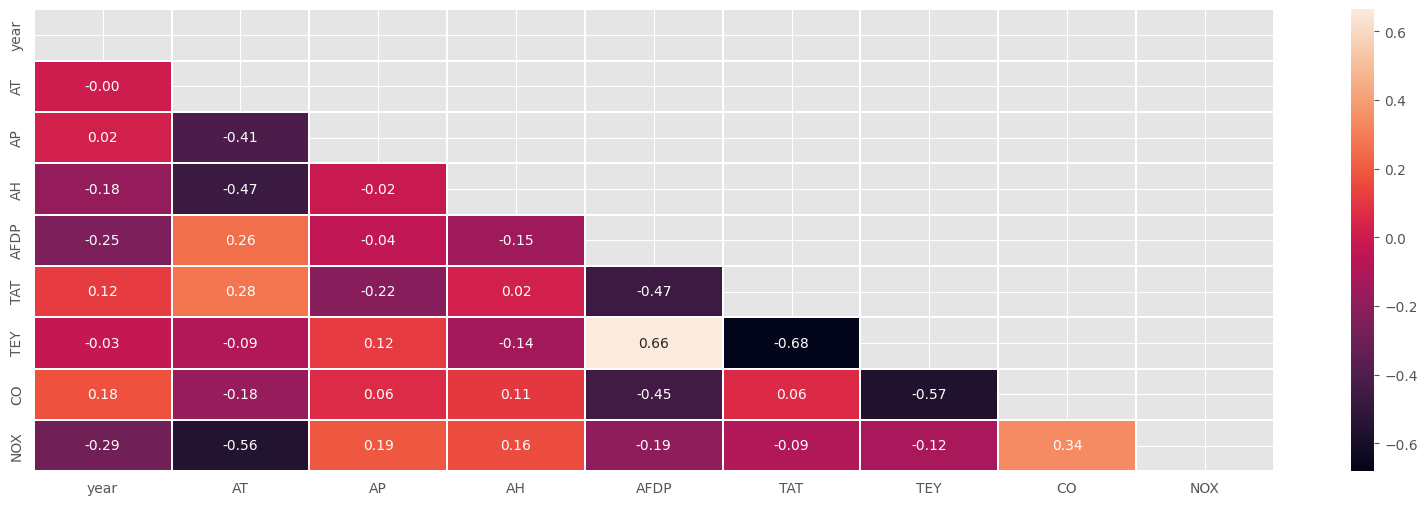

In [30]:
plt.figure(figsize=(20,6))
correlation = pd.concat((X_train_sm,y_train),axis=1).drop('const',axis=1).corr()
mask = np.triu(correlation)
sns.heatmap(correlation,annot=True,mask=mask,fmt='.2f',linewidths=0.05)
plt.show()

In [31]:
Feature_to_keep = X_train.columns.to_list()[1:]

# Model Selection

In [ ]:
KNR = KNeighborsRegressor()
LR = LinearRegression()
SGDR = SGDRegressor()
RFR = RandomForestRegressor()
SVR_ = SVR()

# Dropping columns we find unnecessary after regression analysis
X_train_sm = X_train[Feature_to_keep]
X_test_sm = X_test[Feature_to_keep]

# Feature Transformations
scaler = RobustScaler()

columns_names = list(X_train_sm.columns)
X_train_sm[columns_names] = scaler.fit_transform(X_train_sm[columns_names])
X_test_sm[columns_names] = scaler.transform(X_test_sm[columns_names])

# Traning base models and evaluations
for Name,model in {'KNeighborsRegressor':KNR,'LinearRegression':LR,'SGDRegressor':SGDR,'RandomForestRegressor':RFR,'SupportVectorRegressor':SVR_}.items():
  print(f'---- {Name} ----')
  # Model traning
  score = cross_val_score(model, X_train_sm,y_train,cv=3,scoring='r2')
  model = model.fit(X_train_sm,y_train)
  X_train_sm_preds =  model.predict(X_train_sm)
  X_test_sm_preds =  model.predict(X_test_sm)


  # model evaluation
  print(f'Train MSE : {mean_squared_error(y_train,X_train_sm_preds)}, Train MAE : {mean_absolute_error(y_train,X_train_sm_preds)}, R2 Train : {r2_score(y_train,X_train_sm_preds)}')
  print(f'Test MSE : {mean_squared_error(y_test,X_test_sm_preds)}, Test MAE : {mean_absolute_error(y_test,X_test_sm_preds)}, R2 Test  : {r2_score(y_test,X_test_sm_preds)}')
  print(f'Cross val Avg Score (r2) : {score.mean()}')
  print('\n')


---- KNeighborsRegressor ----
Train MSE : 10.989451197858406, Train MAE : 1.9951862695711369, R2 Train : 0.9200164804238398
Test MSE : 20.08724734862585, Test MAE : 2.6177548299319726, R2 Test  : 0.8571568862210355
Cross val Avg Score (r2) : 0.8505969809347933


---- LinearRegression ----
Train MSE : 59.00713328964749, Train MAE : 5.37965942794937, R2 Train : 0.5705337677348842
Test MSE : 56.87772565471501, Test MAE : 5.332674591375331, R2 Test  : 0.5955348537219571
Cross val Avg Score (r2) : 0.5696176284196229


---- SGDRegressor ----
Train MSE : 59.42946290998554, Train MAE : 5.384802613968111, R2 Train : 0.5674599646078924
Test MSE : 58.10595699194022, Test MAE : 5.365478357200654, R2 Test  : 0.5868007357213565
Cross val Avg Score (r2) : 0.5661607017497406


---- RandomForestRegressor ----
Train MSE : 2.0665889982487116, Train MAE : 0.8920027008168825, R2 Train : 0.9849589339247883
Test MSE : 19.040625017515985, Test MAE : 2.5566960340136053, R2 Test  : 0.8645995581875635
Cross val 

# Fine Tuning

In [ ]:
SVR_ = SVR()

params = {
    'kernel':['poly'],
    'degree':[1,2,3],
    'C':[0.01,0.1,1.0],
    'epsilon':[0.01,0.1,1.0]
}

SVR_scv = GridSearchCV(SVR_, params,scoring='r2')

SVR_result = SVR_scv.fit(X_train_sm,y_train)

best_parmas = SVR_result.best_params_
print('Best Parmeters : ',best_parmas)

best_SVR = SVR_result.best_estimator_
print('Best Estimator : ',best_SVR)

X_train_sm_preds =  best_SVR.predict(X_train_sm)
X_test_sm_preds =  best_SVR.predict(X_test_sm)

# model evaluation
print(f'Train MSE : {mean_squared_error(y_train,X_train_sm_preds)}, Train MAE : {mean_absolute_error(y_train,X_train_sm_preds)}, R2 Train : {r2_score(y_train,X_train_sm_preds)}')
print(f'Test MSE : {mean_squared_error(y_test,X_test_sm_preds)}, Test MAE : {mean_absolute_error(y_test,X_test_sm_preds)}, R2 Test  : {r2_score(y_test,X_test_sm_preds)}')
print('\n')

Best Parmeters :  {'C': 1.0, 'degree': 3, 'epsilon': 1.0, 'kernel': 'poly'}
Best Estimator :  SVR(epsilon=1.0, kernel='poly')
Train MSE : 60.16263756436387, Train MAE : 5.5494430475748135, R2 Train : 0.5621237664424517
Test MSE : 60.21112001989528, Test MAE : 5.520257991238527, R2 Test  : 0.5718306386888217




In [ ]:
RFR = RandomForestRegressor()

params = {
    'n_estimators' : [75,100,150,200],
    'min_samples_split':[25,50,75]
}

RFPGscv = GridSearchCV(RFR, params,scoring='r2')

RF_result = RFPGscv.fit(X_train_sm,y_train)

best_parmas_rfg = RF_result.best_params_
print('Best Parmeters : ',best_parmas_rfg)

best_rfg = RF_result.best_estimator_
print('Best Estimator : ',best_rfg)

X_train_sm_preds =  best_rfg.predict(X_train_sm)
X_test_sm_preds =  best_rfg.predict(X_test_sm)

# model evaluation
print(f'Train MSE : {mean_squared_error(y_train,X_train_sm_preds)}, Train MAE : {mean_absolute_error(y_train,X_train_sm_preds)}, R2 Train : {r2_score(y_train,X_train_sm_preds)}')
print(f'Test MSE : {mean_squared_error(y_test,X_test_sm_preds)}, Test MAE : {mean_absolute_error(y_test,X_test_sm_preds)}, R2 Test  : {r2_score(y_test,X_test_sm_preds)}')
print('\n')

Best Parmeters :  {'C': 1.0, 'degree': 3, 'epsilon': 1.0, 'kernel': 'poly'}
Best Estimator :  RandomForestRegressor(min_samples_split=25, n_estimators=200)
Train MSE : 8.426937400535909, Train MAE : 1.8788845814576431, R2 Train : 0.9386669906979349
Test MSE : 22.00811546031482, Test MAE : 2.847118049716204, R2 Test  : 0.8434973350903953




# Model Evaluation

In [35]:
X_train_sm = X_train[Feature_to_keep]
X_val_sm = X_val[Feature_to_keep]
X_test_sm = X_test[Feature_to_keep]

rs = RobustScaler()
X_train_sm = rs.fit_transform(X_train_sm)
X_val_sm = rs.transform(X_val_sm)
X_test_sm = rs.transform(X_test_sm)

RFR = RandomForestRegressor(min_samples_split=25, n_estimators=200, max_features='log2', oob_score= True)
RFR = RFR.fit(X_train_sm,y_train)

X_train_sm_preds = RFR.predict(X_train_sm)
X_test_sm_preds = RFR.predict(X_test_sm)
X_val_sm_preds = RFR.predict(X_val_sm)

# model evaluation
print(f'Train MSE : {mean_squared_error(y_train,X_train_sm_preds)}, Train MAE : {mean_absolute_error(y_train,X_train_sm_preds)}, R2 Train : {r2_score(y_train,X_train_sm_preds)}')
print(f'Test MSE : {mean_squared_error(y_test,X_test_sm_preds)}, Test MAE : {mean_absolute_error(y_test,X_test_sm_preds)}, R2 Test  : {r2_score(y_test,X_test_sm_preds)}')
print(f'Test MSE : {mean_squared_error(y_val,X_val_sm_preds)}, Test MAE : {mean_absolute_error(y_val,X_val_sm_preds)}, R2 val  : {r2_score(y_val,X_val_sm_preds)}')
print('\n')

Train MSE : 9.943277531317937, Train MAE : 2.075534798090571, R2 Train : 0.9276307507300867
Test MSE : 20.77832482751757, Test MAE : 2.941255325800928, R2 Test  : 0.8522425414512349
Test MSE : 17.09975745829248, Test MAE : 2.7601635659751342, R2 val  : 0.868486411401751




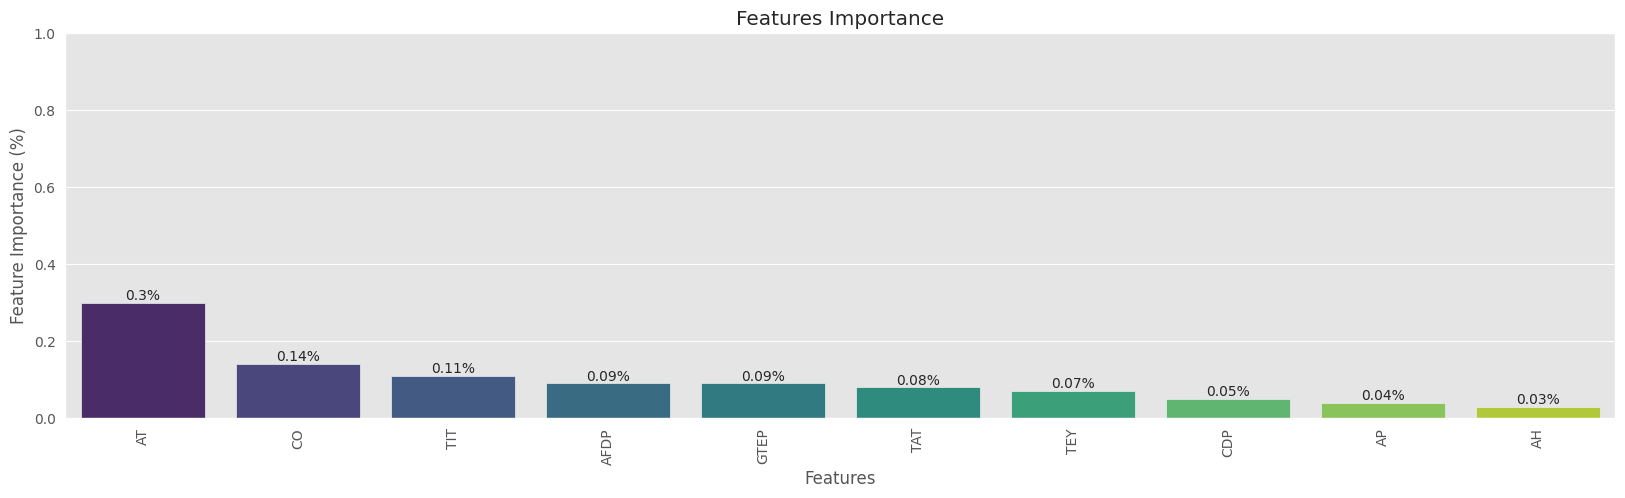

In [56]:
FeatureImportance = pd.DataFrame()
FeatureImportance['Feature Names'] = X_train[Feature_to_keep].columns.to_list()
FeatureImportance['Feature Importance'] = np.round(RFR.feature_importances_,2)
FeatureImportance = FeatureImportance.sort_values(by='Feature Importance',ascending=False)

# Calculating the percent null values in each column

plt.figure(figsize=(20,5))

  # plot count plot
bar_plot = sns.barplot(x='Feature Names', y='Feature Importance',
                        data=FeatureImportance, palette='viridis')

  # Add title and labels
plt.title('Features Importance')
plt.xlabel('Features')
plt.ylabel('Feature Importance (%)')
plt.ylim((0,1))
plt.xticks(rotation=90)

  # Add percentage labels on top of each bar
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}%',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom', fontsize=10)

# Show the plot
plt.show()